# Data loading: LMDB database

## Overview

In this example we will show how to use the data stored in LMDB database (in either Caffe or Caffe 2 formats) with DALI.

## Caffe LMDB format

In order to use data stored in LMDB in Caffe format, we need to use `CaffeReader` operator. Besides arguments common to all readers (like `random_shuffle`), it takes `path` argument - path to the directory where LMDB is stored.

Let us define a simple pipeline that takes images stored in Caffe format, decodes them and prepares them for ingestion in DL framework (crop, normalize and HWC -> CHW conversion).

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import os.path

test_data_root = os.environ['DALI_EXTRA_PATH']
db_folder = os.path.join(test_data_root, 'db', 'lmdb')

class CaffePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(CaffePipeline, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = ops.CaffeReader(path = db_folder)
        self.decode= ops.ImageDecoder(device = "mixed", output_type = types.RGB)
        self.cmnp = ops.CropMirrorNormalize(device = "gpu",
                                            output_dtype = types.FLOAT,
                                            crop = (224, 224),
                                            image_type = types.RGB,
                                            mean = [0., 0., 0.],
                                            std = [1., 1., 1.])
        self.uniform = ops.Uniform(range = (0.0, 1.0))
        self.iter = 0

    def define_graph(self):
        self.jpegs, self.labels = self.input()
        images = self.decode(self.jpegs)
        output = self.cmnp(images, crop_pos_x = self.uniform(),
                           crop_pos_y = self.uniform())
        return (output, self.labels)

    def iter_setup(self):
        pass


Let us now build and run our `CaffePipeline`.

In [2]:
batch_size = 16

pipe = CaffePipeline(batch_size=batch_size, num_threads=4, device_id = 0)
pipe.build()

In [3]:
pipe_out = pipe.run()

In order to visualize the results we use `matplotlib` library. This library expects images in `HWC` format, whereas the output of our pipeline is in `CHW` (since that is the preferred format for most Deep Learning frameworks). Because of that, for the visualization purposes, we need to transpose the images back to `HWC` layout.

In [4]:
from __future__ import division
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        img_chw = image_batch.at(j)
        img_hwc = np.transpose(img_chw, (1,2,0))/255.0
        plt.imshow(img_hwc)

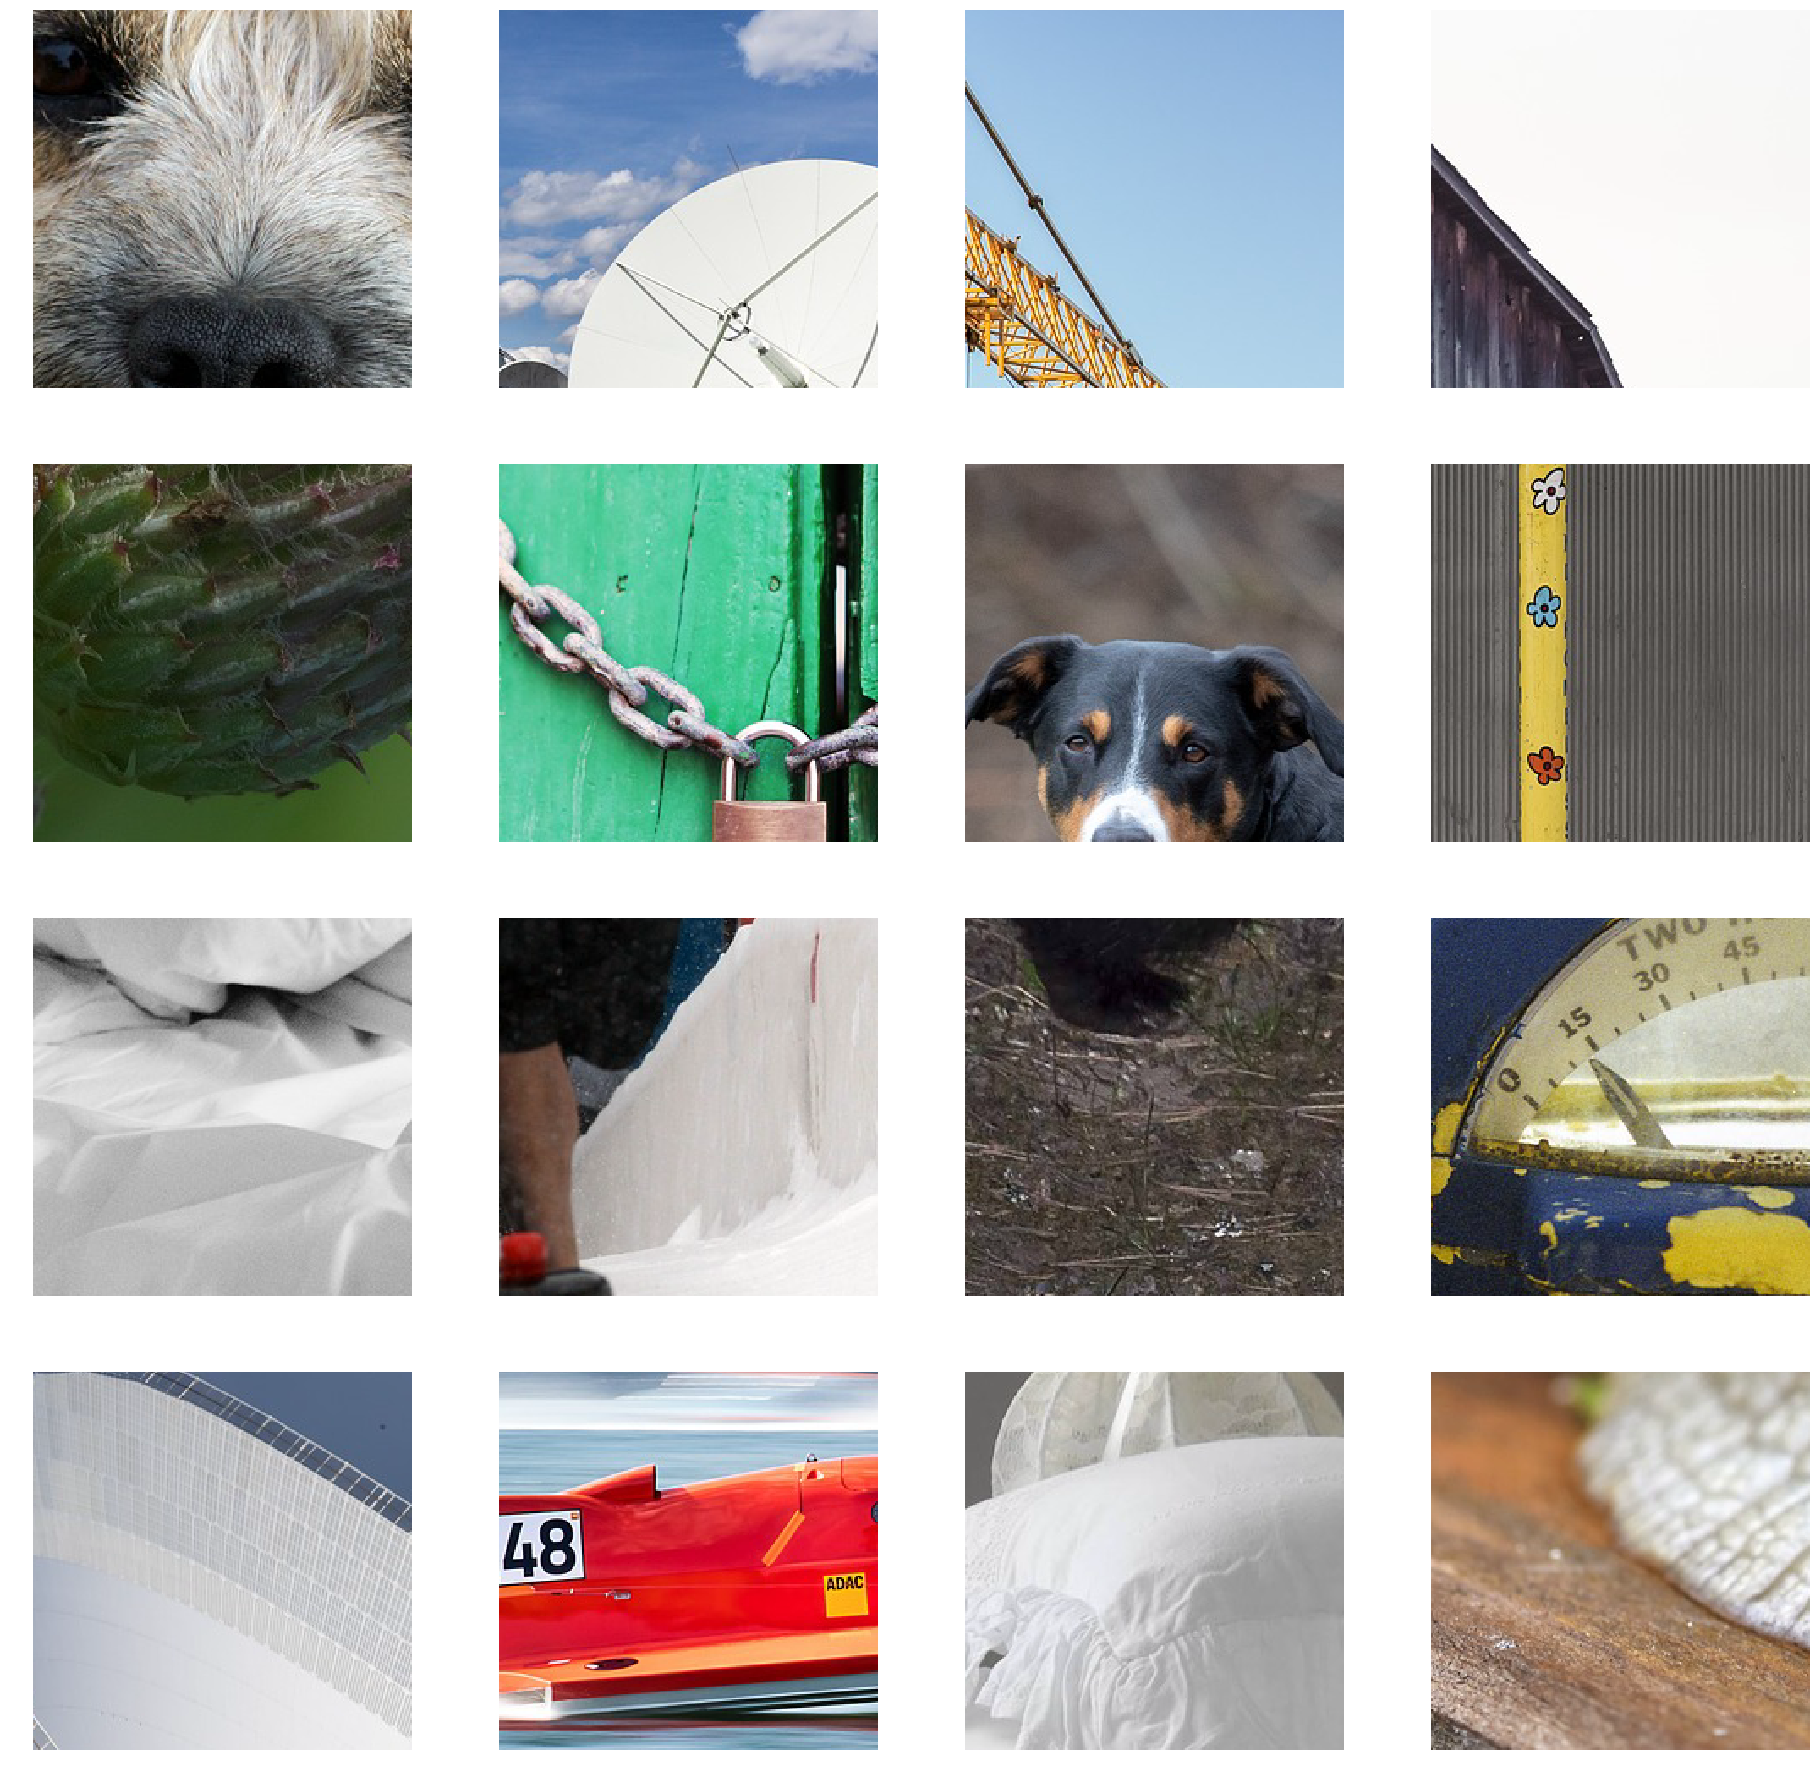

In [5]:
images, labels = pipe_out

show_images(images.as_cpu())

## Caffe 2 LMDB format

In order to use data stored in LMDB in Caffe 2 format, we need to use `Caffe2Reader` operator. Similarly to `CaffeReader`, besides arguments common to all readers (like `random_shuffle`), it takes `path` argument - path to the directory where LMDB is stored.

Let us define a simple pipeline that takes images stored in Caffe 2 format, decodes them and prepares them for ingestion in DL framework (crop, normalize and NHWC -> NCHW conversion).

In [6]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import os.path

test_data_root = os.environ['DALI_EXTRA_PATH']
db_folder = os.path.join(test_data_root, 'db', 'c2lmdb')

class Caffe2Pipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(Caffe2Pipeline, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = ops.Caffe2Reader(path = db_folder)
        self.decode= ops.ImageDecoder(device = "mixed", output_type = types.RGB)
        self.cmnp = ops.CropMirrorNormalize(device = "gpu",
                                            output_dtype = types.FLOAT,
                                            crop = (224, 224),
                                            image_type = types.RGB,
                                            mean = [0., 0., 0.],
                                            std = [1., 1., 1.])
        self.uniform = ops.Uniform(range = (0.0, 1.0))
        self.iter = 0

    def define_graph(self):
        self.jpegs, self.labels = self.input()
        images = self.decode(self.jpegs)
        output = self.cmnp(images, crop_pos_x = self.uniform(),
                           crop_pos_y = self.uniform())
        return (output, self.labels)

    def iter_setup(self):
        pass


Let us now build and run our `Caffe2Pipeline`.

In [7]:
batch_size = 16

pipe = Caffe2Pipeline(batch_size=batch_size, num_threads=4, device_id = 0)
pipe.build()

In [8]:
pipe_out = pipe.run()

In order to visualize the results we use `matplotlib` library. This library expects images in `HWC` format, whereas the output of our pipeline is in `CHW` (since that is the preferred format for most Deep Learning frameworks). Because of that, for the visualization purposes, we need to transpose the images back to `HWC` layout.

In [9]:
from __future__ import division
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        img_chw = image_batch.at(j)
        img_hwc = np.transpose(img_chw, (1,2,0))/255.0
        plt.imshow(img_hwc)

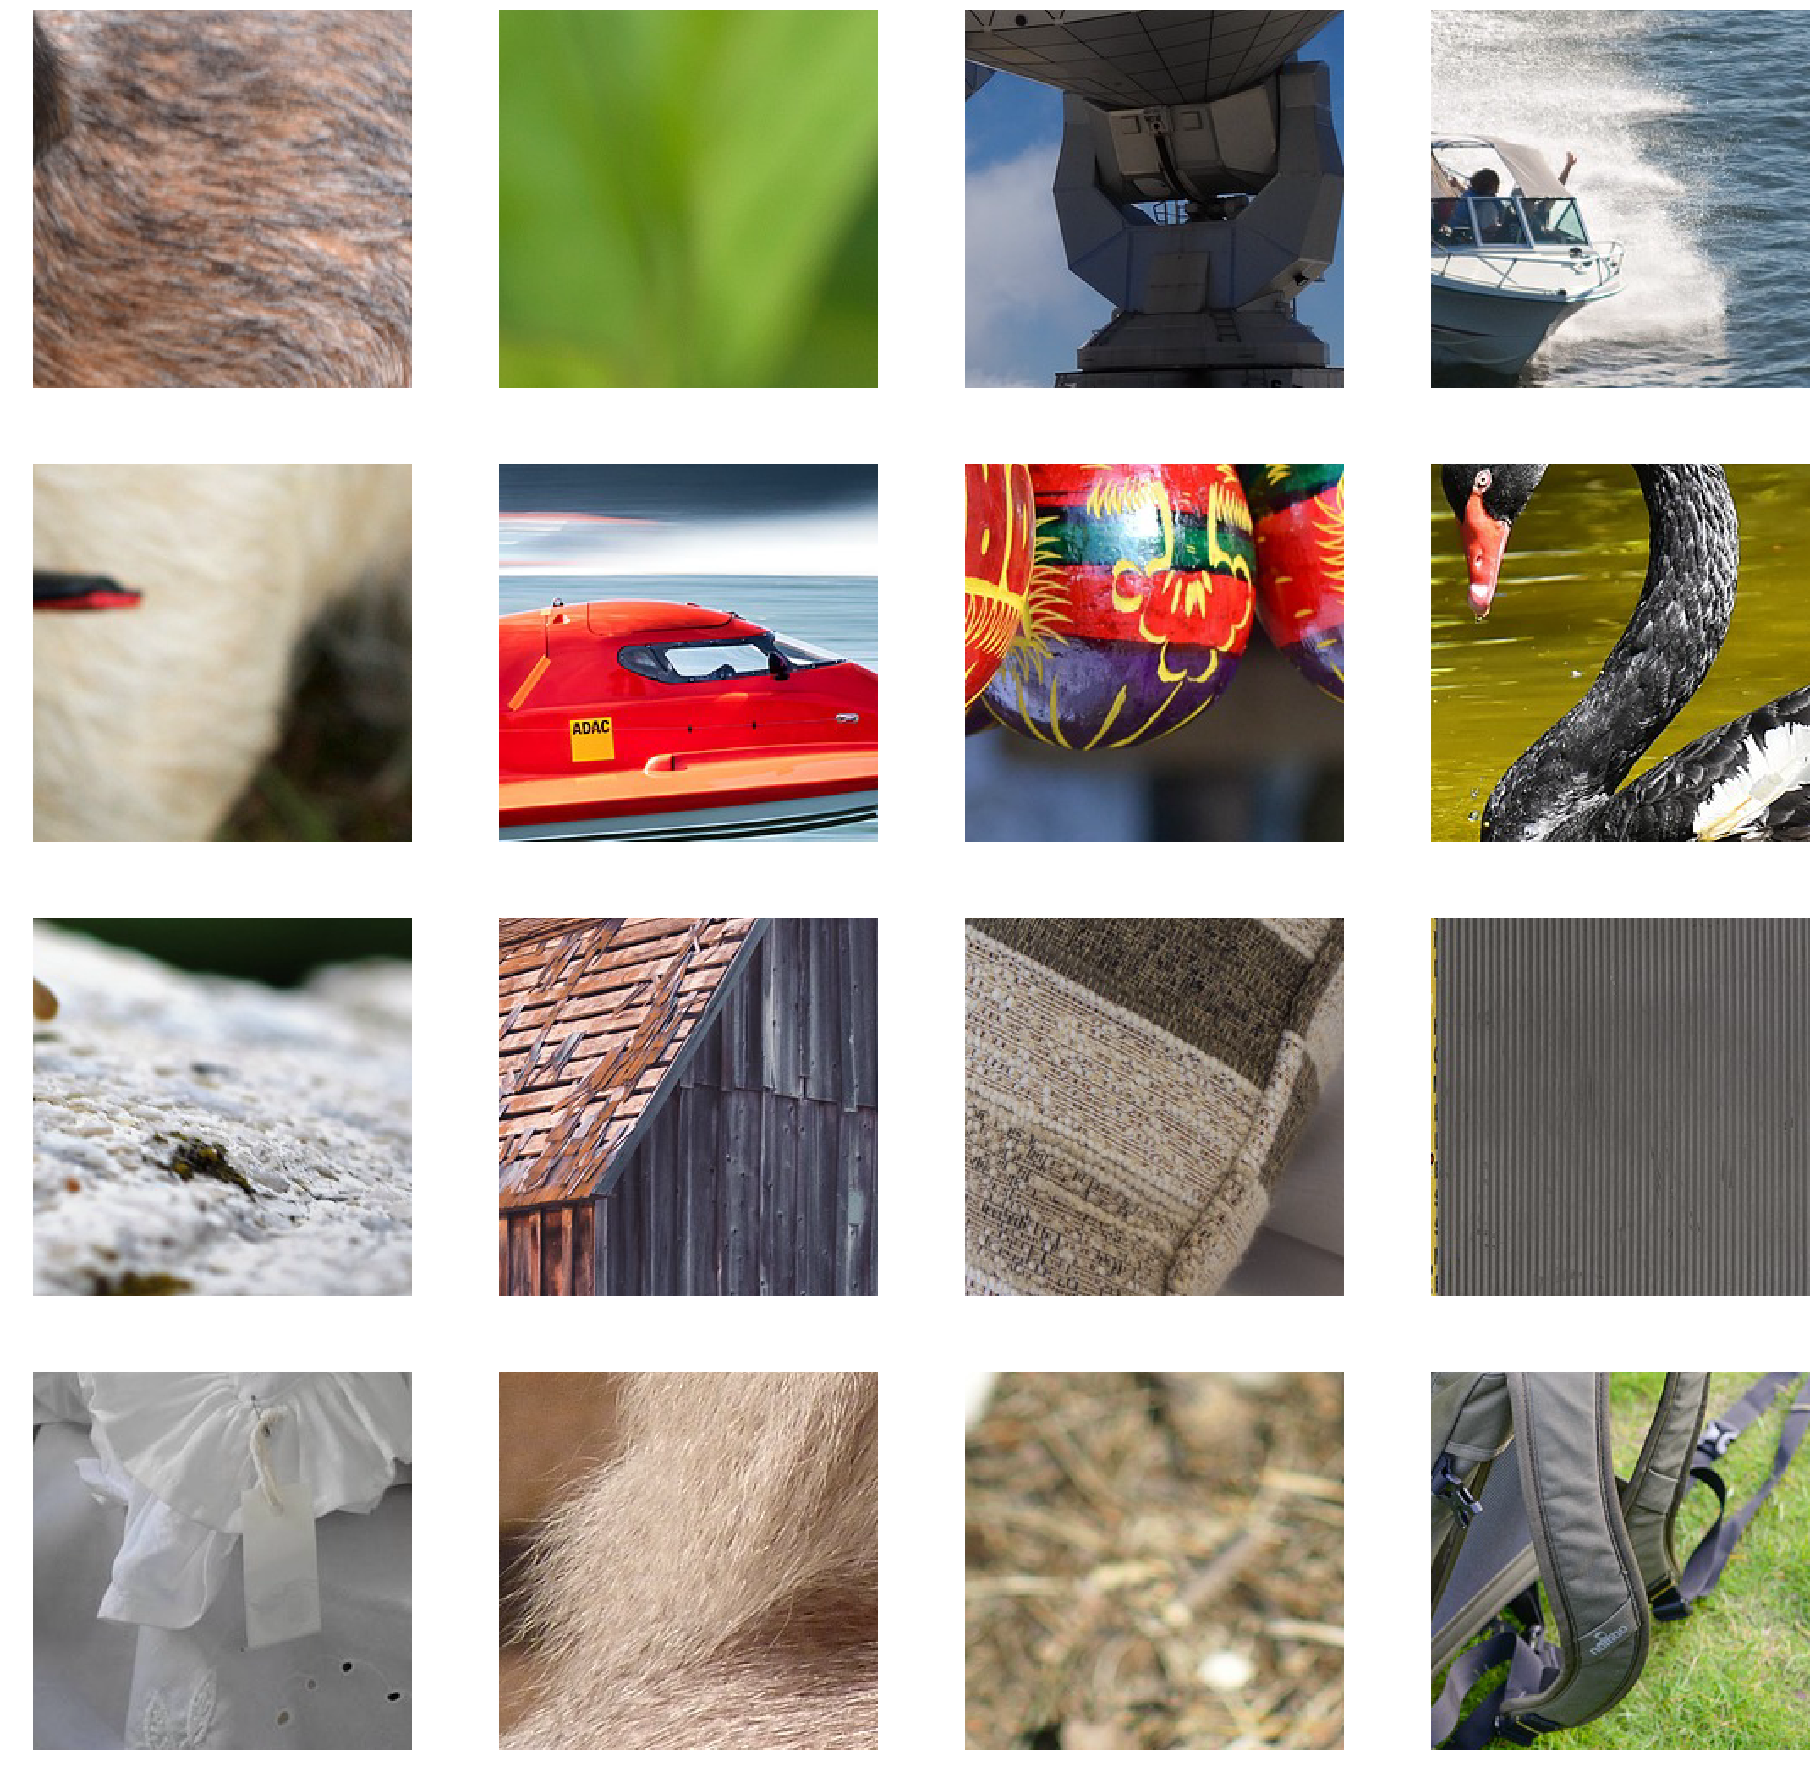

In [10]:
images, labels = pipe_out

show_images(images.as_cpu())